In [1]:
### Imports
# Modules
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utilities
from imgaug import augmenters as iaa
from random import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from utils import crop_resize

# Keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

# Plot in the notebook
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Constants
DATA_DIR = 'data/'
CSV_FILE = 'driving_log.csv'

# Generator parameters
BATCH_SIZE = 32

# Image processing parameters
angle_treshold = 0.1
zero_discard_prob = 0.9
steering_correction = 0.25

### Load data

In [3]:
# Load csv log file
csv_file = []
with open(DATA_DIR+CSV_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_file.append(line)

In [4]:
# Split csv in train and validation sets
csv_train, csv_valid = train_test_split(csv_file, test_size = 0.2)

### Transformation functions

In [5]:
# Image transformations
# Transformation list:
tr_list = [iaa.Add((-75, 75)), # change brightness of images (by -10 to 10 of original value)
           iaa.Multiply((0.5, 2.0)),
           iaa.ContrastNormalization((0.5, 2.0)), # improve or worsen the contrast
           iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
           iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))]
seq = iaa.SomeOf((0,2), tr_list)

In [6]:
# Get sample image for testing
sample_idx = np.random.choice(len(csv_file))
path = DATA_DIR + csv_file[sample_idx][0].strip()
sample_image = cv2.imread(path)
sample_angle = csv_file[sample_idx][3]

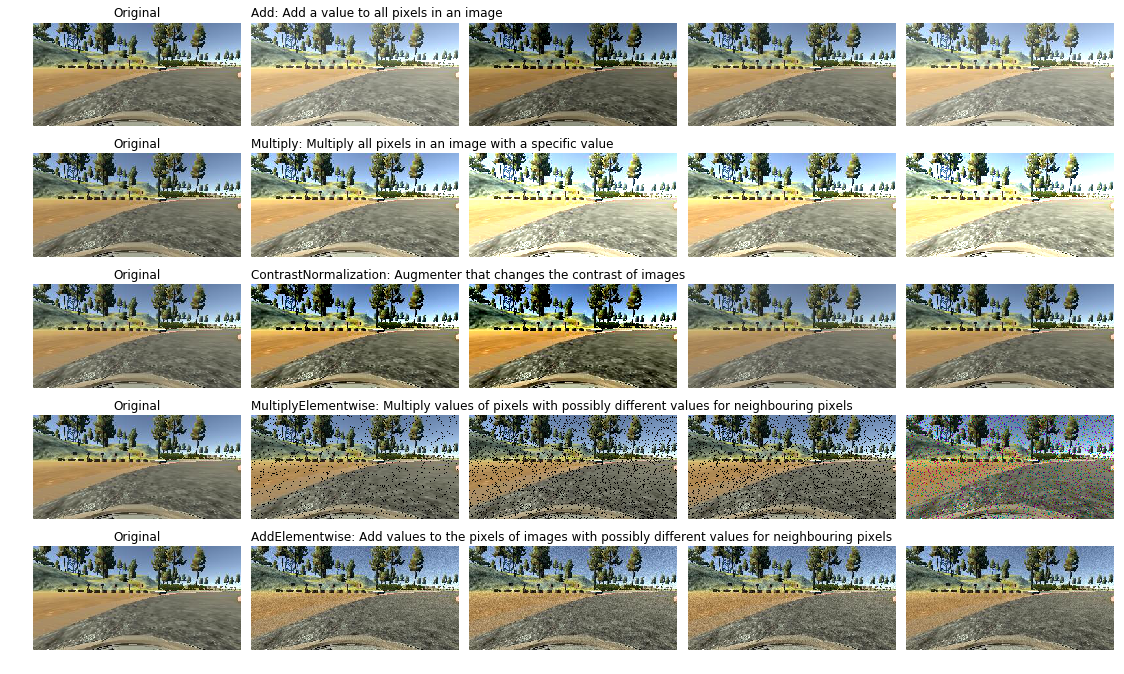

In [7]:
### Test image transformations
# Graph paramters
plot_width, plot_height = 15, 9
grid_rows, grid_cols = 5, 5
sample_size = grid_rows * grid_cols 

# Plot 
fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for tr_fn in tr_list:
    # Print non-transformed image
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    imgplt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Original')
    counter += 1
    # Print transformed images
    tr_images = tr_fn.augment_images([sample_image]*(grid_cols-1))
    print_title = True
    for tr_image in tr_images:
        imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
        imgplt.imshow(cv2.cvtColor(tr_image, cv2.COLOR_BGR2RGB))
        imgplt.axis('off')
        if print_title:
            imgplt.set_title('{}: {}'.format(tr_fn.name[7:],' '.join(tr_fn.__doc__.split('.')[0].split())), loc='left')
            print_title = False
        counter += 1

### Create generators

In [17]:
def transformed_data_generator(csv_file, data_dir = DATA_DIR, batch_size = BATCH_SIZE, zero_discard_prob = zero_discard_prob,
                               image_load = True, resize = True):
    
    # Camera parameters
    cameras = ['center', 'left', 'right']
    cameras_index = {'center':0, 'left':1, 'right':2} # 0:center, 1:left, 2:right
    cameras_steering_corretion = {'center':0, 'left':steering_correction, 'right':-steering_correction}
    
    num_samples = len(csv_file)
    
    cycles = 0
    
    while 1: # Loop forever so the generator never terminates
        
        shuffle(csv_file)
        counter = 0
        images = []
        angles = []
        for idx in range(0, num_samples):
            
            angle = float(csv_file[idx][3])
            ### Discard angles below treshold with certain prob
            if angle < angle_treshold and random() < zero_discard_prob:
                continue
            counter += 1

            ### Randomly choose center, left or right image
            # Get random camera 0:center, 1:left, 2:right 
            camera = np.random.choice(cameras)
            file_name = csv_file[idx][cameras_index[camera]].split('/')[-1]
            path = data_dir + 'IMG/' + file_name
            if image_load:
                image = cv2.imread(path)
            else:
                image = np.zeros((160, 320, 3), dtype = np.uint8)
            # Adjust angle
            angle += cameras_steering_corretion[camera]            
            
            ### Random flip image with 0.5 prob
            if random() > 0.5:
                image = cv2.flip(image,1)
                angle *= -1.    
                        
            images.append(image)
            angles.append(angle)

            if counter == batch_size:
                images = np.array(images)
                ### Randomly apply image transformation
                if image_load:
                    images = seq.augment_images(images)

                ### Resize images
                if resize and image_load:
                    images = [crop_resize(image) for image in images]
                
                X_train = np.array(images)
                y_train = np.array(angles)
                
                counter = 0
                images = []
                angles = []
                
                yield shuffle(X_train, y_train)

In [9]:
def original_data_generator(csv_file, data_dir = DATA_DIR, batch_size = BATCH_SIZE, image_load = True, resize = True):
    
    num_samples = len(csv_file)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(csv_file)
        counter = 0
        images = []
        angles = []
        
        for idx in range(0, num_samples):
            
            file_name = csv_file[idx][0].split('/')[-1]
            path = data_dir + 'IMG/' + file_name
            if image_load:
                image = cv2.imread(path)
            else:
                image = np.zeros((160, 320, 3), dtype = np.uint8)
            angle = float(csv_file[idx][3])
            counter += 1
                        
            images.append(image)
            angles.append(angle)

            if counter == batch_size:
                images = np.array(images)
                ### Resize images
                if resize:
                    images = [crop_resize(image) for image in images]
                
                X_train = np.array(images)
                y_train = np.array(angles)
                
                counter = 0
                images = []
                angles = []
                
                yield shuffle(X_train, y_train)

In [10]:
train_data_generator = transformed_data_generator(csv_train)
valid_data_generator = original_data_generator(csv_valid)

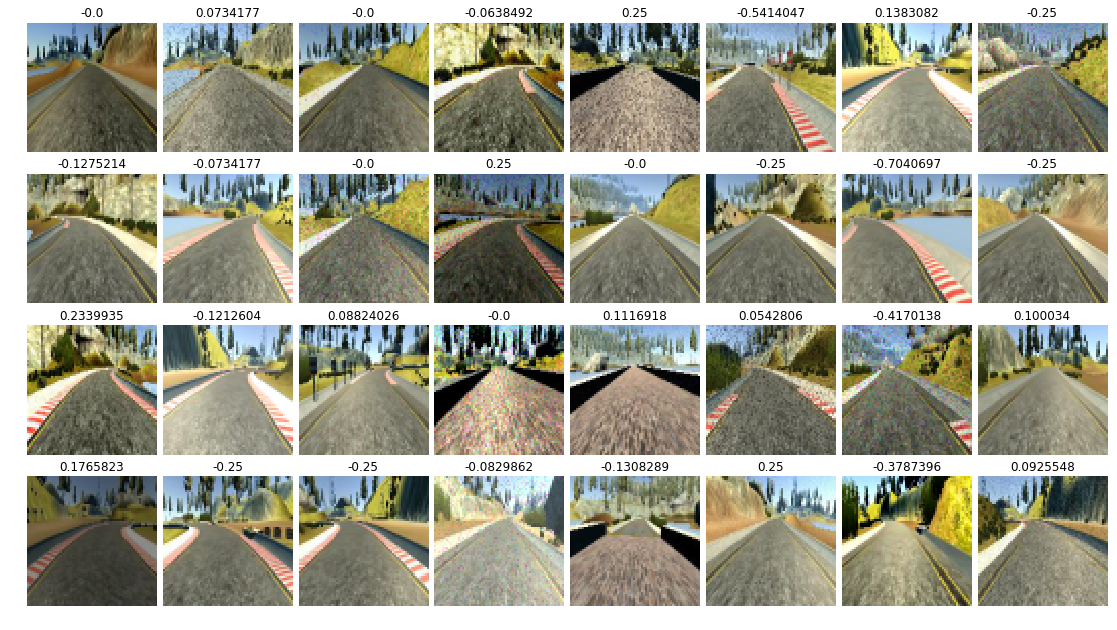

In [11]:
# Test transformed data generator
for images, angles in train_data_generator:
    break

plot_width, plot_height = 15, 8.3
grid_rows, grid_cols = 4, 8

fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for image, angle in zip(images, angles):
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    counter += 1
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title(angle)

Discard angles below 0.100000 with 90.000000% prob


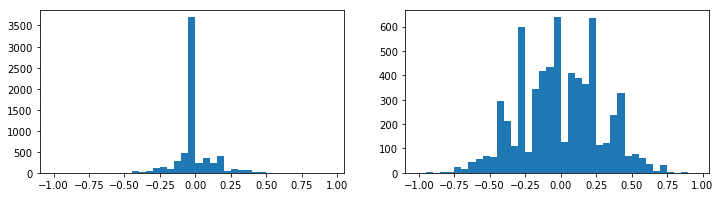

In [12]:
sample_size = 200

print('Discard angles below {:f} with {:%} prob'.format(angle_treshold, zero_discard_prob))

tr_angles = []
counter = 0
for images, angles in transformed_data_generator(csv_train, image_load = False):
    counter += 1
    tr_angles = np.concatenate((tr_angles, angles))
    if counter > sample_size: break

or_angles = []
counter = 0
for images, angles in original_data_generator(csv_train, image_load = False):
    counter += 1
    or_angles = np.concatenate((or_angles, angles))
    if counter > sample_size: break        
        
buckets = np.arange(-1,1,0.05)

fig = plt.figure(figsize = (12, 3))
#fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

hstplt = fig.add_subplot(1, 2, 1)
hist = hstplt.hist(or_angles, bins = buckets)

hstplt = fig.add_subplot(1, 2, 2)
hist = hstplt.hist(tr_angles, bins = buckets)

### Define model

In [15]:
l2_reg_param = 0.001
keep_prob = 0.5
def create_nv_model():
    # Define nvidia model
    model = Sequential()
    # model.add(Cropping2D(cropping=((30,25),(0,0)), input_shape = (160, 320, 3)))
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    model.add(Conv2D(24, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu',
                     kernel_regularizer = l2(l2_reg_param)))
    model.add(Conv2D(36, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu',
                     kernel_regularizer = l2(l2_reg_param)))
    model.add(Conv2D(48, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu',
                     kernel_regularizer = l2(l2_reg_param)))
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (2, 2), activation = 'relu',
                     kernel_regularizer = l2(l2_reg_param)))
    model.add(Conv2D(64, (3, 3), padding = 'valid', strides = (2, 2), activation = 'relu',
                     kernel_regularizer = l2(l2_reg_param)))
    model.add(Flatten())
    model.add(Dense(80))
    model.add(Dropout(keep_prob))
    model.add(Dense(40))
    model.add(Dropout(keep_prob))
    model.add(Dense(16))
    model.add(Dropout(keep_prob))
    model.add(Dense(10))
    model.add(Dense(1))
    # adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

### NVidia model with generator

In [16]:
nv_model = create_nv_model()
nv_history_object = nv_model.fit_generator(transformed_data_generator(csv_train), steps_per_epoch = len(csv_train)/BATCH_SIZE,
                                 epochs=10, #FLAGS.epochs,
                                 validation_data = original_data_generator(csv_valid), validation_steps = len(csv_valid)/BATCH_SIZE)
for images, angles in original_data_generator(csv_valid):
    break
steering_angles = nv_model.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

Epoch 1/10
201/200 [==============================] - 27s - loss: 0.1249 - val_loss: 0.0393
Epoch 2/10
201/200 [==============================] - 25s - loss: 0.0588 - val_loss: 0.0270
Epoch 3/10
201/200 [==============================] - 26s - loss: 0.0489 - val_loss: 0.0266
Epoch 4/10
201/200 [==============================] - 26s - loss: 0.0452 - val_loss: 0.0256
Epoch 5/10
201/200 [==============================] - 26s - loss: 0.0418 - val_loss: 0.0285
Epoch 6/10
201/200 [==============================] - 26s - loss: 0.0416 - val_loss: 0.0288
Epoch 7/10
201/200 [==============================] - 25s - loss: 0.0389 - val_loss: 0.0285
Epoch 8/10
201/200 [==============================] - 25s - loss: 0.0393 - val_loss: 0.0259
Epoch 9/10
201/200 [==============================] - 26s - loss: 0.0383 - val_loss: 0.0265
Epoch 10/10
201/200 [==============================] - 26s - loss: 0.0384 - val_loss: 0.0259


ValueError: Error when checking : expected lambda_2_input to have shape (None, 64, 64, 3) but got array with shape (32, 160, 320, 3)

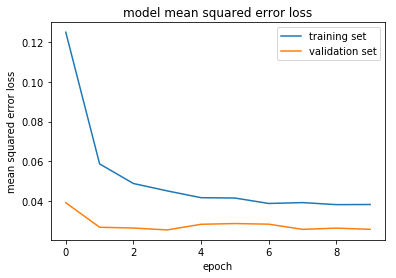

In [18]:
### plot the training and validation loss for each epoch
plt.plot(nv_history_object.history['loss'])
plt.plot(nv_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [19]:
# Save model
nv_model.save('models/nv_model.h5')

## Fine tune model

In [20]:
nv_model_ft = load_model('models/nv_model.h5')

In [21]:
for idx_layer in range(len(nv_model_ft.layers)):
    print(idx_layer, nv_model_ft.layers[idx_layer])
    
for layer in nv_model_ft.layers:
    layer.trainable = True
# for layer in nv_model_ft.layers[:-8]:
#     print(layer)
#     layer.trainable = False

0 <keras.layers.core.Lambda object at 0x7fe4e018d390>
1 <keras.layers.convolutional.Conv2D object at 0x7fe4e01de278>
2 <keras.layers.convolutional.Conv2D object at 0x7fe4e01de2b0>
3 <keras.layers.convolutional.Conv2D object at 0x7fe4e01d3128>
4 <keras.layers.convolutional.Conv2D object at 0x7fe4e015abe0>
5 <keras.layers.convolutional.Conv2D object at 0x7fe4e00baeb8>
6 <keras.layers.core.Flatten object at 0x7fe4e0100e10>
7 <keras.layers.core.Dense object at 0x7fe4e008cd68>
8 <keras.layers.core.Dropout object at 0x7fe4e00b5780>
9 <keras.layers.core.Dense object at 0x7fe4e00e4b38>
10 <keras.layers.core.Dropout object at 0x7fe4e0060d30>
11 <keras.layers.core.Dense object at 0x7fe4e00b5390>
12 <keras.layers.core.Dropout object at 0x7fe4cc7e2da0>
13 <keras.layers.core.Dense object at 0x7fe4e0060da0>
14 <keras.layers.core.Dense object at 0x7fe4cc7a6e10>


In [22]:
# for layer in nv_model_ft.layers[:]:
#     layer.trainable = False
# adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.0005, momentum=0.0, decay=0.9, nesterov=False)
nv_model_ft.compile(loss = 'mse', optimizer = sgd)
nv_model_ft.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________

In [23]:
### Get data for fine tuning
FT_DATA_DIR = 'getting-out-data/'
FT_DATA_FILE = 'driving_log.csv'

# Load csv log file
csv_ft_file = []
with open(FT_DATA_DIR+FT_DATA_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_ft_file.append(line)
# Split csv in train and validation sets
csv_ft_train, csv_ft_valid = train_test_split(csv_ft_file, test_size = 0.2)

In [25]:
nv_history_object = nv_model_ft.fit_generator(transformed_data_generator(csv_ft_train, data_dir = 'getting-out-data/', zero_discard_prob = 2.0), steps_per_epoch = len(csv_ft_train)/BATCH_SIZE,
                                 epochs=5, #FLAGS.epochs,
                                 validation_data = original_data_generator(csv_ft_valid, data_dir = 'getting-out-data/'), validation_steps = len(csv_ft_valid)/BATCH_SIZE)
for images, angles in original_data_generator(csv_valid):
    break
steering_angles = nv_model_ft.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

Epoch 1/5
57/56 [==============================] - 8s - loss: 0.2694 - val_loss: 0.1501
Epoch 2/5
57/56 [==============================] - 7s - loss: 0.2802 - val_loss: 0.1483
Epoch 3/5
57/56 [==============================] - 7s - loss: 0.2707 - val_loss: 0.1510
Epoch 4/5
57/56 [==============================] - 6s - loss: 0.2633 - val_loss: 0.1502
Epoch 5/5
57/56 [==============================] - 7s - loss: 0.2666 - val_loss: 0.1524
Predicted	Angle	Abs. diff.
-0.042507	0.061760	0.104267
-0.128667	0.000000	0.128667
-0.011305	0.000000	0.011305
0.108403	0.000000	0.108403
-0.031106	0.000000	0.031106
-0.187477	-0.534475	0.346998
-0.023976	0.000000	0.023976
-0.169320	0.000000	0.169320
-0.187944	0.000000	0.187944
0.016134	0.000000	0.016134
0.221276	0.272268	0.050992
-0.198858	0.224425	0.423283
0.125224	0.071328	0.053896
-0.061169	0.128740	0.189909
-0.036628	0.000000	0.036628
0.014032	0.000000	0.014032
0.396590	0.000000	0.396590
-0.117599	0.000000	0.117599
0.195914	0.119171	0.076743
-0.3915

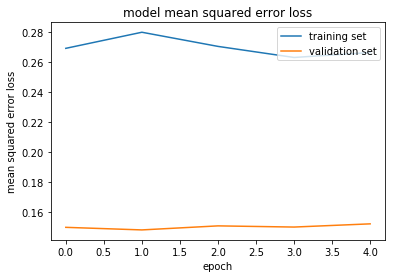

In [26]:
### plot the training and validation loss for each epoch
plt.plot(nv_history_object.history['loss'])
plt.plot(nv_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [28]:
### Get data for fine tuning
FT_DATA_DIR = 'new-data/'
FT_DATA_FILE = 'driving_log.csv'

# Load csv log file
csv_ft_file = []
with open(FT_DATA_DIR+FT_DATA_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_ft_file.append(line)
# Split csv in train and validation sets
csv_ft_train, csv_ft_valid = train_test_split(csv_ft_file, test_size = 0.2)

In [30]:
nv_history_object = nv_model_ft.fit_generator(transformed_data_generator(csv_ft_train, data_dir = 'new-data/'), steps_per_epoch = len(csv_ft_train)/BATCH_SIZE,
                                 epochs=10, #FLAGS.epochs,
                                 validation_data = original_data_generator(csv_ft_valid, data_dir = 'new-data/'), validation_steps = len(csv_ft_valid)/BATCH_SIZE)
for images, angles in original_data_generator(csv_valid):
    break
steering_angles = nv_model_ft.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

Epoch 1/10
167/166 [==============================] - 22s - loss: 0.0608 - val_loss: 0.0351
Epoch 2/10
167/166 [==============================] - 21s - loss: 0.0611 - val_loss: 0.0348
Epoch 3/10
167/166 [==============================] - 21s - loss: 0.0617 - val_loss: 0.0347
Epoch 4/10
167/166 [==============================] - 21s - loss: 0.0616 - val_loss: 0.0347
Epoch 5/10
167/166 [==============================] - 21s - loss: 0.0609 - val_loss: 0.0348
Epoch 6/10
167/166 [==============================] - 21s - loss: 0.0617 - val_loss: 0.0345
Epoch 7/10
167/166 [==============================] - 21s - loss: 0.0610 - val_loss: 0.0352
Epoch 8/10
167/166 [==============================] - 21s - loss: 0.0608 - val_loss: 0.0353
Epoch 9/10
167/166 [==============================] - 21s - loss: 0.0616 - val_loss: 0.0348
Epoch 10/10
167/166 [==============================] - 21s - loss: 0.0622 - val_loss: 0.0347
Predicted	Angle	Abs. diff.
-0.126246	0.000000	0.126246
-0.050574	-0.126218	0.07

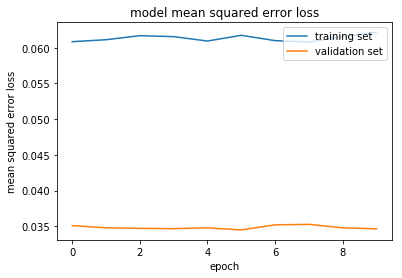

In [31]:
### plot the training and validation loss for each epoch
plt.plot(nv_history_object.history['loss'])
plt.plot(nv_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [32]:
# Save model
nv_model_ft.save('models/nv_model_ft.h5')